Import all the packages we will use

In [41]:
# so editing bimpy source code will reload without restarting the Jupyter kernal
%load_ext autoreload
%autoreload 2

import math
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt

import bimpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load a stack and all its analysis.

In [42]:
#path = '/Users/cudmore/box/Sites/DeepVess/data/20200228/blur/20200228__0001_z.tif'
#path = '/Users/cudmore/box/Sites/DeepVess/data/20200127/blur/20200127_gel_0011.tif'
path = '/Users/cudmore/box/Sites/DeepVess/data/20191017/blur/20191017__0001.tif'
path = '/Users/cudmore/box/data/nathan/vascular-tracing/20191017/tifs/20191017_0002.tif'

stack = bimpy.bStack(path=path, loadImages=True)

# do this when I add new analysis to bImPy code
# I am re-analyzing here because I added 'tort' to analysis and is not in saved h5f file.
'''
if not stack.slabList.hasFile['h5f']:
    print('analyzing then saving h5f file ...')
    stack.slabList._analyze()
    stack.saveAnnotations() # save h5f file
'''
stack.slabList._printInfo()

=== bVascularTracing.load() /Users/cudmore/box/data/nathan/vascular-tracing/20191017/tifs/20191017_0002.h5f
    loaded nodes: 128 edges: 142
bVascularTracing.makeGraph() created self.G with 
    nodeDictList: 129 edgeDictList: 143
    number_of_nodes: 129
    number_of_edges: 143
    connected_components: 5
20191017_0002.tif slabs: 3656 nodes: 129 edges: 143
len(x) 3656
len(y) 3656
len(z) 3656
len(d) 3656
len(d2) 3656
len(int) 3656
len(edgeIdx) 3656
len(nodeIdx) 3656


### Only do this once, can be very slow ...

Analyze the diameter of each slab/point in the tracing.

This is slow (20-30 sec). I need to add this to main code so it is saved with other analysis.

There are a few parameters here that can be important for the analysis of each slab

- lineWidth: Width of line to extract intensity profile
- meadianFilter: Number of pixels in median filter applied to line profile
- radius: [CRITICAL] The radius of the line intensity profile. If too short, vessel will not be covered, if too long, line will collide with other vessels.


In [36]:
# this is slow and should just be done once, we save results and they are reloaded next time
stack.slabList.analyseSlabIntensity()
stack.slabList._analyze() # fills in new bimpy edge.['Diam2'] for each edge
stack.saveAnnotations() # save h5f file

print('done')

analyseSlabIntensity() analyzing intensity of all slabs across edges: 142 ...
    edgeIdx: 0 of 142 edges
    edgeIdx: 20 of 142 edges
    edgeIdx: 40 of 142 edges
    edgeIdx: 60 of 142 edges
    edgeIdx: 80 of 142 edges
    edgeIdx: 100 of 142 edges
    edgeIdx: 120 of 142 edges


/Users/cudmore/Sites/bImPy/bImPy_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



    edgeIdx: 140 of 142 edges
   number of slabs analyzed: 3004  took 17.96 seconds
bVascularTracing._analyze() thisEdgeIdx: None len(thisEdgeDictList): 142
=== bVascularTracing.save()
   h5FilePath: /Users/cudmore/box/Sites/DeepVess/data/20191017/blur/20191017__0001.h5f
done


In [43]:
meanDiamList = []
meanDiamList2 = []
lengthList = []
tortList = []
nEdges = stack.slabList.numEdges()
for edgeIdx in range(nEdges):
    edgeDict = stack.slabList.getEdge(edgeIdx)
    meanDiamList.append(edgeDict['Diam']) # vessellucida
    meanDiamList2.append(edgeDict['Diam2']) # vessellucida
    lengthList.append(edgeDict['Len 3D'])
    tortList.append(edgeDict['Tort'])

    
def getStat(aList):
    theMean = np.nanmean(aList)
    theSD = np.nanstd(aList)
    theN = np.count_nonzero(~np.isnan(aList))
    theSE = theSD / math.sqrt(theN)
    return theMean, theSD, theSE, theN

m,sd,se,n = getStat(meanDiamList2)
print('bImpy vessel diameter: mean', m, 'sd:', sd, 'se:', se, 'n:', n)
m,sd,se,n = getStat(meanDiamList)
print('Vesselucida vessel diameter: mean', m, 'sd:', sd, 'se:', se, 'n:', n)
m,sd,se,n = getStat(lengthList)
print('Vessel length: mean', m, 'sd:', sd, 'se:', se, 'n:', n)
m,sd,se,n = getStat(tortList)
print('Vessel Tortuosity: mean', m, 'sd:', sd, 'se:', se, 'n:', n)

# ask if the Vesselucida and bImpy vessel diameters are the same ...
from scipy import stats
clean1 = [x for x in meanDiamList2 if str(x) != 'nan']
clean2 = [x for x in meanDiamList if str(x) != 'nan']
t, p = stats.ttest_ind(clean1, clean2) # vessel diameter from Vesselucida vs bImPy
print('ttest t:', t, 'p:', p)


bImpy vessel diameter: mean nan sd: nan se: nan n: 0
Vesselucida vessel diameter: mean 199.31335664335663 sd: 49.56423455249666 se: 4.14476951266427 n: 143
Vessel length: mean 3313.7833566433565 sd: 3702.017454950282 se: 309.57825176089585 n: 143
Vessel Tortuosity: mean 1.1699300699300699 sd: 0.35899528894876553 se: 0.0300206942013592 n: 143
ttest t: nan p: nan


/Users/cudmore/Sites/bImPy/bImPy_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

Mean of empty slice

/Users/cudmore/Sites/bImPy/bImPy_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning:

Degrees of freedom <= 0 for slice.



<IPython.core.display.Javascript object>


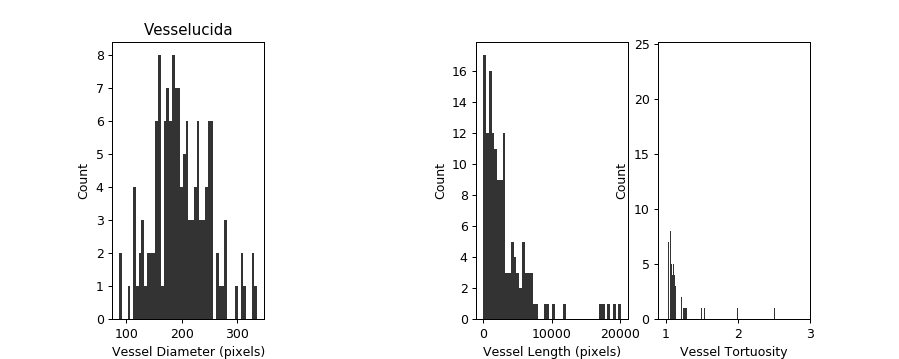

In [45]:
# plot the results

fig = plt.figure(figsize=(10,4))

alpha = 0.8 #0.75

ax = plt.subplot(141)
ax.set_title('Vesselucida')
n, bins, patches = plt.hist(meanDiamList, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Diameter (pixels)')
plt.ylabel('Count')


'''
ax = plt.subplot(142)
ax.set_title('bImPy')
n, bins, patches = plt.hist(meanDiamList2, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Diameter (pixels)')
plt.ylabel('Count')
'''

plt.subplot(143)
n, bins, patches = plt.hist(lengthList, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Length (pixels)')
plt.ylabel('Count')

ax = plt.subplot(144)
n, bins, patches = plt.hist(tortList, 500, density=False, facecolor='k', alpha=alpha)
ax.set_xlim(0.9, 3)
plt.xlabel('Vessel Tortuosity')
plt.ylabel('Count')

#plt.grid(True)
plt.show()


<IPython.core.display.Javascript object>


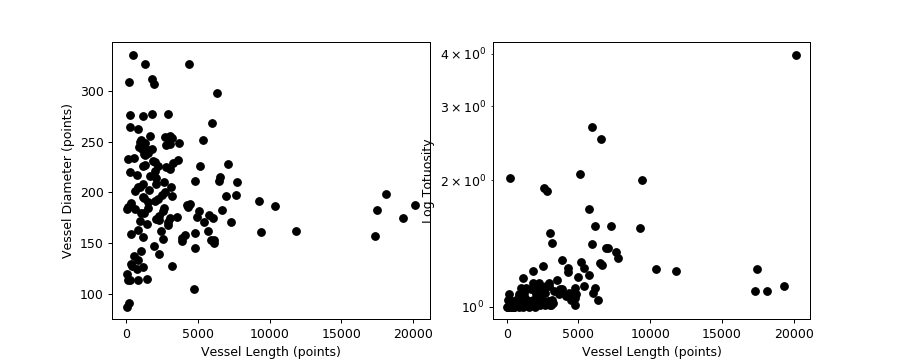

In [46]:
fig = plt.figure(figsize=(10,4))
alpha = 0.8 #0.75

ax = plt.subplot(121)
ax.set_title('')
#ax.plot(lengthList, meanDiamList2, 'ok')
ax.plot(lengthList, meanDiamList, 'ok')
plt.xlabel('Vessel Length (points)')
plt.ylabel('Vessel Diameter (points)')

ax = plt.subplot(122)
ax.set_title('')
ax.plot(lengthList, tortList, 'ok')
ax.set_yscale("log")
plt.xlabel('Vessel Length (points)')
plt.ylabel('Log Totuosity')

plt.show()
